In [3]:
# import required libraries

import deeplake
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Load GTZAN Dataset

In [4]:
# deeplake GTZAN dataset citation information:
# @ONLINE {kaggle-diabetic-retinopathy,
#     author = "Kaggle and EyePacs",
#     title  = "Kaggle Diabetic Retinopathy Detection",
#     month  = "jul",
#     year   = "2015",
#     url    = "https://www.kaggle.com/c/diabetic-retinopathy-detection/data"
# }

# GTZAN dataset includes audio tracks recognized into 10 different genres
# each audio track is labeled with genre

# load dataset into python
dataset = deeplake.load("hub://activeloop/gtzan-genre")

|

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/gtzan-genre



/

hub://activeloop/gtzan-genre loaded successfully.



# Visualize Data
Check dataset structure. Visualize audiofiles through iframe.

In [5]:
# documentation on: https://docs.activeloop.ai/examples/dl/guide/visualizing-datasets
# pip install deeplake[visualizer] for visualize() command

dataset.summary() # tensor layout inspection
dataset.visualize() # visualization using an iframe 

Dataset(path='hub://activeloop/gtzan-genre', read_only=True, tensors=['audio', 'genre'])

 tensor      htype              shape             dtype  compression
 -------    -------            -------           -------  ------- 
  audio      audio     (1000, 660000:675808, 1)  float64    wav   
  genre   class_label         (1000, 1)          uint32    None   
HINT: Please forward the port - 52438 to your local machine, if you are running on the cloud.
 * Serving Flask app 'dataset_visualizer'
 * Debug mode: off


Explanation of structure:
2 Tensors: Audio and Genre

Audio:
- 1000 audio tracks
- 660000 to 675808 (length of each audio track = duration * sample rate) - should all be equal, however differences in recording cause fluctuation
- 1 audio channel (mono)
- currently, the tracks are 22050Hz Mono 16-bit audio files in .wav format.

Genre:
- 1000 class labels
- 1 for each audio track
- data type: unsigned integer 32 bit

# Utility Functions
Ensure that all samples have the same sample rate (samples of audio per second) - needed for consistent CNN inputs.
Normalization of data. Feature extractions into spectrograms.
- for converting audio .wav to mel spectrogram
- for accessing genre name from integer
- for displaying mel spectrogram
- for displaying MFCC

In [14]:
# functionality: takes in audio input tensor and computes melspectrogram representation
# sample rate (sr) = 22050 samples per second
# n_fft = number of samples used for each Fourier transform - determines frequency resolution of spectrogram
# hop_length = number of samples between successive frames - time resolution of spectrogram
# n_mels = number of mel frequency bins - determines number of frequency bands in spectrogram

# mel spectrogram representation
def audio_to_melspectrogram(audio_tensor, sr=22050, n_fft=4096, hop_length=1024, n_mels=256):
    # convert tensor to numpy array (librosa uses numpy instead of torch tensors)
    audio_array = audio_tensor.numpy()

    # compute mel spectrogram - look at comments above function for explanation
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_array.squeeze(), sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    # convert to decibels - for better visualization & normalizing by specifying a reference power level (db converted relative to np.max)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    return mel_spectrogram_db

# MFCC representation - different representation of audio signal
def audio_to_mfcc(audio_tensor, sr=22050, n_fft=4096, hop_length=1024, n_mfcc=60):
    # convert tensor to numpy array
    audio_array = audio_tensor.numpy()
    
    # compute MFCC
    mfcc = librosa.feature.mfcc(y=audio_array.squeeze(), sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    
    return mfcc

# maps a genre label (in its integer form) to corresponding genre name
def genre_tensor_to_string(genre_number):
    # map number to genre name
    number_genre_map = {0:"Pop", 1:"Metal", 2:"Classical", 3:"Rock", 4:"Blues", 5:"Jazz",
                        6:"Hip-hop", 7:"Reggae", 8:"Disco", 9:"Country"}

    return number_genre_map[genre_number]

# function to display spectrogram
def plot_spectrogram(spectrogram, genre):
    plt.figure(figsize=(10, 4)) # setup figure: 10 inch height, 4 inch width
    librosa.display.specshow(spectrogram, sr=22050, x_axis='time', y_axis='mel') # display spectrogram: time vs mel frequency
    plt.colorbar(format='%+2.0f dB') # color bar label for visualization (to show dB scale)
    # label axes
    plt.title(f'Mel Spectrogram of {genre.lower()} song')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    # format fitting
    plt.tight_layout()
    # plot!
    plt.show()

# function to display MFCC
def plot_mfcc(mfcc, genre):
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mfcc, x_axis='time', cmap='viridis')

    # add a color bar which maps values to colors.
    plt.colorbar(format='%+2.0f dB')

    # add labels
    plt.title(f'Mel-frequency cepstral coefficients (MFCC) of {genre.lower()} song')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficient')

    # show plot
    plt.tight_layout()
    plt.show()

# Compute Genre List

In [10]:
# create list of genre labels in tensor format (we will change to string later)
genre_labels = []

for genre_tensor in dataset["genre"]:
    genre_labels.append(genre_tensor.numpy()[0]) # to a numpy array, and access element

# Compute Mel Spectrograms

In [9]:
# create list of spectrograms
spectrograms = []

# compute the mel spectrogram for each audio sample
for audio_tensor in dataset["audio"]:
    spectrograms.append(audio_to_melspectrogram(audio_tensor))

# Visualization of Mel Spectrogram
- Choose which song to visualize: index = 0-999
- It's beautiful

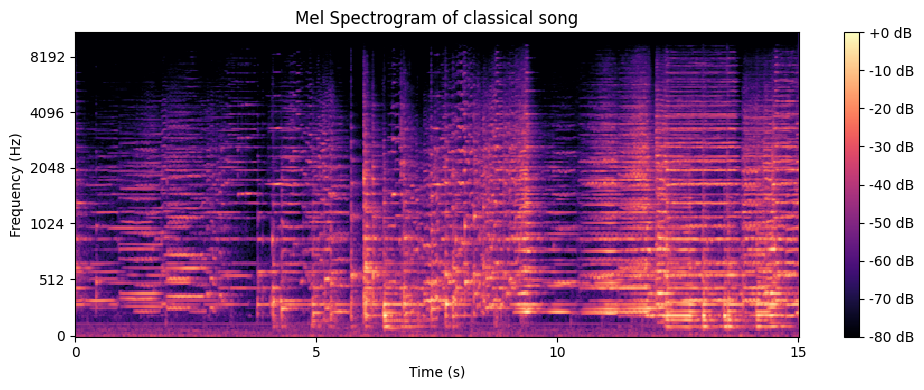

spectrogram shape (256, 647)


In [11]:
index = 200
# pop : 0-99
# metal: 100 - 199
# classical: 200 - 299
# rock: 300 - 399
# blues: 400 - 499
# jazz: 500 - 599
# hip-hop: 600 - 699
# reggae: 700 - 799
# disco: 800 - 899
# country: 900 - 999

plot_spectrogram(spectrograms[index], genre_tensor_to_string(genre_labels[index])) # uint32 tensor -> uint32 numpy -> string
print('spectrogram shape', spectrograms[index].shape)

# Compute MFCCs

In [12]:
# create list of mfcc values for each song
mfccs = []

# compute the MFCC for each audio sample
for audio_tensor in dataset["audio"]:
    mfccs.append(audio_to_mfcc(audio_tensor))

# Visualize MFCCs
- Choose which song to display; index = 0-999
- It's not that visually pleasing

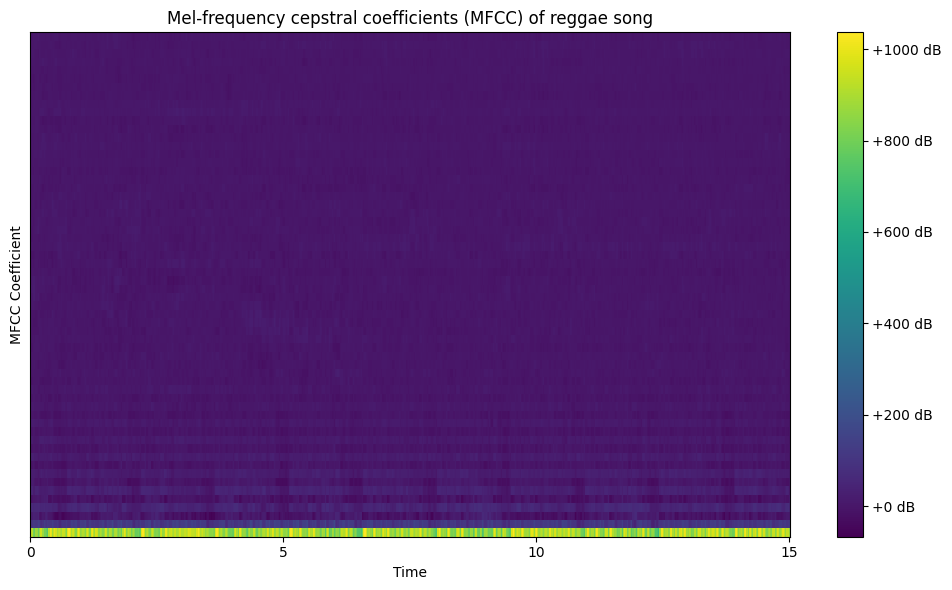

MFCC shape (60, 647)


In [15]:
index = 700
# pop : 0-99
# metal: 100 - 199
# classical: 200 - 299
# rock: 300 - 399
# blues: 400 - 499
# jazz: 500 - 599
# hip-hop: 600 - 699
# reggae: 700 - 799
# disco: 800 - 899
# country: 900 - 999

plot_mfcc(mfccs[index], genre_tensor_to_string(genre_labels[index]))
print('MFCC shape', mfccs[index].shape)

# Data preprocessing
Pad the Mel Spectrogram and MFCC to ensure the image is 1400 pixels wide - for standardization and easy passing of data to CNN

In [41]:
def pad_numpy_columns(numpy_arrs, target_number=1400):
    # pad each spectrogram to have the target number of columns
    padded_numpy_arrs = []
    for arr in numpy_arrs:
        num_columns_to_pad = target_number - arr.shape[1]
        if num_columns_to_pad > 0:
            # pad with zeros to the right (after the spectrogram)
            padded_arr = np.pad(arr, ((0, 0), (0, num_columns_to_pad)), mode='constant')
        else:
            # no padding needed
            padded_arr = arr
        padded_numpy_arrs.append(padded_arr)
    
    return padded_numpy_arrs

In [42]:
# pad spectrograms here
padded_spectrograms = pad_numpy_columns(spectrograms, target_number=1400)

# pad MFCCs here
padded_mfccs = pad_numpy_columns(mfccs, target_number=1400)

In [43]:
# shape should be (256, 1400)
print('spectrogram shape', padded_spectrograms[0].shape)

# shape should be (60, 1400)
print('MFCC shape', padded_mfccs[0].shape)

spectrogram shape (256, 1400)
MFCC shape (60, 1400)


# K Nearest Neighbors
- Flatten the spectrograms, create KNN model for spectrograms, and train
- Flatten the MFCCs, create the KNN model for MFCCs, and train

In [44]:
# flatten spectrograms
spectrograms_flat = [spec.flatten() for spec in padded_spectrograms]

# train KNN model on spectrograms
x1_train, x1_test, y1_train, y1_test = train_test_split(spectrograms_flat, genre_labels, test_size=0.2, random_state=51)
knn_model_spectrograms = KNeighborsClassifier(n_neighbors=5)
knn_model_spectrograms.fit(x1_train, y1_train)

KNeighborsClassifier()

In [45]:
# check model accuracy
y1_pred = knn_model_spectrograms.predict(x1_test)

accuracy = accuracy_score(y1_test, y1_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.38


In [46]:
# flatten MFCCs
mfccs_flat = [mfcc.flatten() for mfcc in padded_mfccs]

# train KNN model on MFCCs
x2_train, x2_test, y2_train, y2_test = train_test_split(mfccs_flat, genre_labels, test_size=0.2, random_state=51)
knn_model_mfccs = KNeighborsClassifier(n_neighbors=5)
knn_model_mfccs.fit(x2_train, y2_train)

KNeighborsClassifier()

In [47]:
# check model accuracy
y2_pred = knn_model_mfccs.predict(x2_test)

accuracy = accuracy_score(y2_test, y2_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.33


# Convolutional Neural Network
- Use padded spectrograms to train the CNN

In [48]:
# import libraries from keras to help produce a CNN

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape
from keras.utils import to_categorical

In [49]:
# split data into training and testing set
# use padded spectrograms
x1_train, x1_test, y1_train, y1_test = train_test_split(padded_spectrograms, genre_labels, test_size=0.2, random_state=51)

# encode categorical label to one-hot encoded vectors for testing
# 10 genres
y1_train_encoded = to_categorical(y1_train, num_classes=10)
y1_test_encoded = to_categorical(y1_test, num_classes=10)

# convert data into numpy arrays
x1_train_array = np.array(x1_train)
x1_test_array = np.array(x1_test)

y1_train_encoded_array = np.array(y1_train_encoded)
y1_test_encoded_array = np.array(y1_test_encoded)

In [50]:
x1_train_array.shape

(800, 256, 1400)

# Define, Train, and Test CNN model architecture

In [51]:
# define the CNN model architecture
model = Sequential()
model.add(Reshape((256, 1400, 1), input_shape=(256, 1400)))  # add a channel dimension
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu')) # 32 filters of size 3x3
model.add(MaxPooling2D(pool_size=(2, 2))) # max pool to take most important features of image
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model and test on validation data
model.fit(x1_train_array, y1_train_encoded_array, batch_size=32, epochs=15, validation_data=(x1_test_array, y1_test_encoded_array))

C:\Users\bryle\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.1158 - loss: 6808.1870 - val_accuracy: 0.1100 - val_loss: 2003.0132
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 148s 6s/step - accuracy: 0.1219 - loss: 984.2885 - val_accuracy: 0.1750 - val_loss: 162.0373
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 169s 7s/step - accuracy: 0.2234 - loss: 138.9548 - val_accuracy: 0.1700 - val_loss: 52.4463
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.3505 - loss: 36.5578 - val_accuracy: 0.3250 - val_loss: 21.0294
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - accuracy: 0.4551 - loss: 16.8133 - val_accuracy: 0.2650 - val_loss: 16.3926
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 133s 5s/step - accuracy: 0.5407 - loss: 14.2808 - val_accuracy: 0.3250 - val_loss: 9.8746
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.6884 - loss: 2.6720 - val_accuracy: 0.3850 - val_loss: 9.2847
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 163s 6s/step - accuracy: 0.7494 - loss: 1.8412 - val_ac